In [1]:
import sys
sys.path.append('/home/andrea/Dropbox/CIMAT/TESIS/lstmsss/keypoints/partes')
import numpy as np
from process_file import process_file_modif
from process_file import process_file_modif_varios
import batches_data
import model

import tensorflow as tf 
tf.reset_default_graph()

import entrenamientoevaluacion
from entrenamientoevaluacion import evaluate
from interaccion_no_normalizada import batch_vecinos

In [2]:
zara01_pix_path = '../data1/ucy/zara/zara01/mundo/mun_pos.csv'
class parameters:
    def __init__(self):
        self.person_max = 22 # 8
        self.obs_len = 8
        self.pred_len = 12
        self.add_social = True
        self.kp_num = 18
        self.add_kp = False

In [3]:
# Cargamos los argumentos
arguments = parameters()

# Procesamos los datos de Zara0X
data_zara01 = process_file_modif(zara01_pix_path, arguments, ',')

El numero total de ejemplos
2356


# Calculamos el flujo optico

In [4]:
#vector = batch_vecinos(data_zara01['obs_person'],data_zara01['key_idx'],data_zara01['obs_traj'],arguments)
#np.save('flujo_bien_non_zara01_total_mundo_12.npy',vector )

# cargamos el flujo optico


In [6]:
vector_flujo = 'flujo_bien_non_zara01_total_mundo_12.npy'
flujo = np.load(vector_flujo)
flujo.shape

(2356, 8, 64)

# Adjuntamos el flujo al diccionario

In [7]:
data_zara01.update({
    "obs_flujo": flujo,
        })

# Dividimos los datos

In [8]:
#se fija la semilaa
import random
random.seed(0)

# Muestreamos aleatoriamente para separar datos de entrenamiento, validacion y prueba
prob = 0.7 
# La cantidad total de listas de tam 8 
ndata = len(data_zara01[list(data_zara01.keys())[2]])
idx = random.sample(range(ndata), ndata)
long1 = int(ndata*prob)
long2 = int(ndata*0.2)
long3 = int(ndata-long1-long2)

idx_train = idx[0:long1]
idx_test = idx[long1:long1+long2]
idx_val = idx[long1+long2:]

# conjunto de entrenamiento
data1 = {
     "obs_traj": data_zara01["obs_traj"][idx_train],
     "obs_traj_rel": data_zara01["obs_traj_rel"][idx_train],
    
     "pred_traj": data_zara01["pred_traj"][idx_train],
     "pred_traj_rel": data_zara01["pred_traj_rel"][idx_train],
    
     "key_idx": data_zara01["key_idx"][[idx_train]],
    
     
     "obs_flujo" : data_zara01["obs_flujo"][idx_train],
     #"pred_kp": data_pets["pred_kp"][idx_train],
     #"obs_person": data_pets["obs_person"][idx_train],
}

# Conjunto de prueba
data2 = {
     "obs_traj": data_zara01["obs_traj"][idx_test],
     "obs_traj_rel": data_zara01["obs_traj_rel"][idx_test],
     "pred_traj": data_zara01["pred_traj"][idx_test],
     "pred_traj_rel": data_zara01["pred_traj_rel"][idx_test],
     "key_idx": data_zara01["key_idx"][[idx_test]],
     "obs_flujo" : data_zara01["obs_flujo"][idx_test],
     #"pred_kp": data_pets["pred_kp"][idx_test],
     #"obs_person": data_pets["obs_person"][idx_test]
}

# conjunto de validacion
data3 ={
     "obs_traj": data_zara01["obs_traj"][idx_val],
     "obs_traj_rel": data_zara01["obs_traj_rel"][idx_val],
     "pred_traj": data_zara01["pred_traj"][idx_val],
     "pred_traj_rel": data_zara01["pred_traj_rel"][idx_val],
     "key_idx": data_zara01["key_idx"][[idx_val]],
     "obs_flujo" : data_zara01["obs_flujo"][idx_val],
     #"pred_kp": data_pets["pred_kp"][idx_val],
     #"obs_person": data_pets["obs_person"][idx_val],
}


#if arguments.add_kp:
#  print(data3['obs_person_rel'])

print("data_train: "+ str(len(data1[list(data1.keys())[0]])))
print("data_test: "+ str(len(data2[list(data2.keys())[0]])))
print("data_val: "+ str(len(data3[list(data3.keys())[0]])))
#print("data4: "+ str(len(data4[list(data4.keys())[0]])))


data_train: 1649
data_test: 471
data_val: 236


/home/andrea/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:26: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/home/andrea/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:40: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/home/andrea/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:52: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will re

# Guardamos la divison de los datos

In [9]:
import pickle

#conjunto de entrenamiento
pickle_out = open("data1_non_zara01_12.pickle","wb")
pickle.dump(data1, pickle_out, protocol=2)
pickle_out.close()

#conjunto de prueba
pickle_out = open("data2_non_zara01_12.pickle","wb")
pickle.dump(data2, pickle_out, protocol=2)
pickle_out.close()

#conjunto de validacion
pickle_out = open("data3_non_zara01_12.pickle","wb")
pickle.dump(data3, pickle_out, protocol=2)
pickle_out.close()

# Parametros para entrenar el modelo

In [13]:
class parameters1:
    def __init__(self, add_kp = None, add_social=None, train_num_examples=None):
        # -----------------
        # Similar a como se procesaron los datos
        self.obs_len = 8
        self.pred_len = 12
        if add_kp is None:
            print('Parameter add kpp missing')
            return
        if train_num_examples is None:
            print('El parametro train_examples fue olvidado')
            return
        if add_social is None:
            print('Parameter add social missing')
            return
        
        self.add_kp = add_kp
        self.train_num_examples = train_num_examples
        self.add_social = add_social
        
        self.kp_num = 18
        self.kp_size = 18
        #self.maxNumPed = 8
        #self.grid_size = 4
        #self.neighborhood_size = 32
        #self.dimensions = [768,576]
        #self.limites=[-15.88,11.56,-19.09,5.99]
        #self.bound=[0.7,0.5]
        # ------------------
        self.num_epochs = 100
        self.batch_size = 20 # batch size
        self.validate = 300
        self.P = 2 # dimensión
        self.enc_hidden_size = 128 # el nombre lo dice
        self.dec_hidden_size = 128
        self.emb_size = 64
        self.keep_prob = 0.7 # dropout
        
        self.min_ped = 1
        self.seq_len = self.obs_len + self.pred_len
        self.reverse_xy = False
        
        self.activation_func = tf.nn.tanh
        self.activation_func1 = tf.nn.relu
        self.is_train = True
        self.is_test = False
        self.multi_decoder = False
        self.modelname = 'gphuctl'
        
        self.init_lr = 0.002 # 0.01
        self.learning_rate_decay = 0.85
        self.num_epoch_per_decay = 2.0
        self.optimizer = 'adam'
        self.emb_lr = 1.0
        #self.clip_gradient_norm = 10.0
        #Para cuando entreno y quiero guardar el mejor modelo
        self.load_best = True

# Entrenamos el modelo

In [14]:
import os 
from tqdm import tqdm
import tensorflow as tf
import math

tf.reset_default_graph()

arguments = parameters1(add_kp = False, add_social = True,train_num_examples=len(data1['obs_traj']))
model = model.Model(arguments)

train_data = batches_data.Dataset(data1,arguments)
val_data = batches_data.Dataset(data3,arguments)

saver = tf.train.Saver(max_to_keep = 2)
bestsaver = tf.train.Saver(max_to_keep = 2)


trainer = entrenamientoevaluacion.Trainer(model,arguments)
tester = entrenamientoevaluacion.Tester(model, arguments)

#inicializamos las variables globales
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

increment_global_step_op = tf.assign(model.global_step, model.global_step+1)

val_perf = []
loss = -1
metric = 'ade'

best = {metric:999999, 'fde':0, 'step':-1}
is_start = True

num_steps = int(math.ceil(train_data.num_examples/float(arguments.batch_size)))
loss_list = []
print(num_steps)

for i in range(arguments.num_epochs):
    print('Epoca {0}.' .format(i+1), 'lr:', sess.run(trainer.get_lr()))
    
    #For de batches
    for idx, batch in tqdm(train_data.get_batches(arguments.batch_size,num_steps = num_steps),total=num_steps):
        
        sess.run(increment_global_step_op)
        global_step = sess.run(model.global_step)

        #Evaluamos el entrenamiento
        if((global_step%arguments.validate==0) or (arguments.load_best and is_start)):
            tqdm.write("\tsaving model %s..." % global_step)
            checkpoint_path_model = os.path.join('sin_KP_NoN_Zara01_social12', 'model.ckpt')
            saver.save(sess,checkpoint_path_model , global_step = global_step)
            tqdm.write("\tdone")
            
            print('Evaluating')
            results = evaluate(val_data, tester,sess,arguments)
            print(results)
           
            tqdm.write(("\t last loss:%.9f, eval on validation:%s,"
                    " (best %s:%s at step %s) ") % (loss,["%s: %s" % (k, results[k]) for k in sorted(results.keys())], metric,best[metric], best["step"]))
            if results["ade"]< best[metric]:
                best[metric] = results["ade"]
                best["fde"] =results["fde"]
                best["step"] = global_step
                
                tqdm.write("\t saving best model...")
                checkpoint_path_model_best = os.path.join('sin_KP_NoN_Zara01_social-best12', 'model_best.ckpt')
                bestsaver.save(sess,checkpoint_path_model_best,global_step = global_step)
                tqdm.write("\t done.")
                finalperf = results
                val_perf.append((loss, results))
            is_start = False
        loss, train_op = trainer.step(sess, batch)
        loss_list.append(loss)
    
if((global_step % arguments.validate)!=0):
  checkpoint_path_model = os.path.join('sin_KP_NoN_Zara01_social12', 'model.ckpt')
  saver.save(sess,checkpoint_path_model , global_step = global_step)

print("best eval on val %s: %s at %s step y fde es %s " % (metric, best[metric], best["step"],best["fde"]))
       


W1227 08:08:11.072087 139680819443456 deprecation_wrapper.py:119] From /home/andrea/Dropbox/CIMAT/TESIS/lstmsss/keypoints/partes/model.py:13: The name tf.get_variable is deprecated. Please use tf.compat.v1.get_variable instead.

W1227 08:08:11.098932 139680819443456 deprecation_wrapper.py:119] From /home/andrea/Dropbox/CIMAT/TESIS/lstmsss/keypoints/partes/model.py:31: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1227 08:08:11.122308 139680819443456 deprecation.py:323] From /home/andrea/Dropbox/CIMAT/TESIS/lstmsss/keypoints/partes/model.py:70: __init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
W1227 08:08:11.124120 139680819443456 deprecation_wrapper.py:119] From /home/andrea/Dropbox/CIMAT/TESIS/lstmsss/keypoints/partes/model.py:72: The name tf.nn.rnn_cell.DropoutW

83
('Epoca 1.', 'lr:', 0.002)
	saving model 1...



  0%|          | 0/12 [00:00<?, ?it/s]

	done
Evaluating



100%|##########| 12/12 [00:00<00:00, 24.49it/s]

{'ade': 2.4809835, 'fde': 4.568712}
	 last loss:-1.000000000, eval on validation:['ade: 2.4809835', 'fde: 4.568712'], (best ade:999999 at step -1) 
	 saving best model...


  4%|▎         | 3/83 [00:00<00:03, 23.22it/s]

	 done.
('Epoca 2.', 'lr:', 0.002)


  1%|          | 1/83 [00:00<00:09,  8.22it/s]

('Epoca 3.', 'lr:', 0.0017000001)


  1%|          | 1/83 [00:00<00:09,  8.50it/s]

('Epoca 4.', 'lr:', 0.0017000001)


 59%|█████▉    | 49/83 [00:02<00:01, 25.09it/s]

	saving model 300...
	done
Evaluating



100%|##########| 12/12 [00:00<00:00, 62.07it/s]

{'ade': 0.45314646, 'fde': 0.9947417}
	 last loss:0.000471652, eval on validation:['ade: 0.45314646', 'fde: 0.9947417'], (best ade:2.4809835 at step 1) 
	 saving best model...
	 done.


  1%|          | 1/83 [00:00<00:10,  7.93it/s]

('Epoca 5.', 'lr:', 0.0014450002)


  1%|          | 1/83 [00:00<00:08,  9.47it/s]

('Epoca 6.', 'lr:', 0.0014450002)


  4%|▎         | 3/83 [00:00<00:03, 25.21it/s]

('Epoca 7.', 'lr:', 0.0012282502)


  1%|          | 1/83 [00:00<00:10,  8.06it/s]

('Epoca 8.', 'lr:', 0.0012282502)


 19%|█▉        | 16/83 [00:00<00:03, 18.76it/s]W1227 08:08:41.749191 139680819443456 deprecation.py:323] From /home/andrea/anaconda2/lib/python2.7/site-packages/tensorflow/python/training/saver.py:960: remove_checkpoint (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to delete files with this prefix.

  0%|          | 0/12 [00:00<?, ?it/s]

	saving model 600...
	done
Evaluating



100%|##########| 12/12 [00:00<00:00, 87.70it/s]

{'ade': 0.4094324, 'fde': 0.8966665}
	 last loss:0.000504969, eval on validation:['ade: 0.4094324', 'fde: 0.8966665'], (best ade:0.45314646 at step 300) 
	 saving best model...
	 done.


  1%|          | 1/83 [00:00<00:08,  9.46it/s]

('Epoca 9.', 'lr:', 0.0010440127)


  4%|▎         | 3/83 [00:00<00:03, 25.96it/s]

('Epoca 10.', 'lr:', 0.0010440127)


  4%|▎         | 3/83 [00:00<00:03, 25.81it/s]

('Epoca 11.', 'lr:', 0.0008874108)


  0%|          | 0/12 [00:00<?, ?it/s]

	saving model 900...
	done
Evaluating



 87%|████████▋ | 72/83 [00:03<00:00, 13.74it/s]

{'ade': 0.41533285, 'fde': 0.9174002}
	 last loss:0.000490408, eval on validation:['ade: 0.41533285', 'fde: 0.9174002'], (best ade:0.4094324 at step 600) 


  1%|          | 1/83 [00:00<00:09,  8.36it/s]

('Epoca 12.', 'lr:', 0.0008874108)


  1%|          | 1/83 [00:00<00:09,  8.44it/s]

('Epoca 13.', 'lr:', 0.0007542992)


  1%|          | 1/83 [00:00<00:09,  8.75it/s]

('Epoca 14.', 'lr:', 0.0007542992)


  1%|          | 1/83 [00:00<00:09,  8.60it/s]

('Epoca 15.', 'lr:', 0.0006411543)


  0%|          | 0/12 [00:00<?, ?it/s]

	saving model 1200...
	done
Evaluating



 48%|████▊     | 40/83 [00:01<00:03, 13.58it/s]

{'ade': 0.4132845, 'fde': 0.91293955}
	 last loss:0.000487882, eval on validation:['ade: 0.4132845', 'fde: 0.91293955'], (best ade:0.4094324 at step 600) 


  4%|▎         | 3/83 [00:00<00:03, 23.03it/s]

('Epoca 16.', 'lr:', 0.0006411543)


  1%|          | 1/83 [00:00<00:09,  8.34it/s]

('Epoca 17.', 'lr:', 0.0005449812)


  4%|▎         | 3/83 [00:00<00:03, 25.89it/s]

('Epoca 18.', 'lr:', 0.0005449812)


  4%|▎         | 3/83 [00:00<00:03, 25.66it/s]

('Epoca 19.', 'lr:', 0.00046323403)
	saving model 1500...



  7%|▋         | 6/83 [00:00<00:05, 13.76it/s]]

	done
Evaluating
{'ade': 0.40988272, 'fde': 0.901295}
	 last loss:0.000426216, eval on validation:['ade: 0.40988272', 'fde: 0.901295'], (best ade:0.4094324 at step 600) 


  4%|▎         | 3/83 [00:00<00:03, 25.46it/s]

('Epoca 20.', 'lr:', 0.00046323403)


  4%|▎         | 3/83 [00:00<00:03, 25.39it/s]

('Epoca 21.', 'lr:', 0.00039374892)


  4%|▎         | 3/83 [00:00<00:03, 24.51it/s]

('Epoca 22.', 'lr:', 0.00039374892)


 65%|██████▌   | 54/83 [00:02<00:01, 24.78it/s]

	saving model 1800...



100%|##########| 12/12 [00:00<00:00, 78.82it/s]

	done
Evaluating
{'ade': 0.41052365, 'fde': 0.8964897}
	 last loss:0.000484393, eval on validation:['ade: 0.41052365', 'fde: 0.8964897'], (best ade:0.4094324 at step 600) 


  4%|▎         | 3/83 [00:00<00:03, 25.97it/s]

('Epoca 23.', 'lr:', 0.0003346866)


  4%|▎         | 3/83 [00:00<00:03, 24.62it/s]

('Epoca 24.', 'lr:', 0.0003346866)


  2%|▏         | 2/83 [00:00<00:05, 15.99it/s]

('Epoca 25.', 'lr:', 0.00028448363)


  4%|▎         | 3/83 [00:00<00:03, 26.20it/s]

('Epoca 26.', 'lr:', 0.00028448363)


  0%|          | 0/12 [00:00<?, ?it/s]

	saving model 2100...
	done
Evaluating



100%|##########| 12/12 [00:00<00:00, 66.87it/s]

{'ade': 0.39389735, 'fde': 0.8577695}
	 last loss:0.000552080, eval on validation:['ade: 0.39389735', 'fde: 0.8577695'], (best ade:0.4094324 at step 600) 
	 saving best model...


 33%|███▎      | 27/83 [00:01<00:05, 10.24it/s]

	 done.


  4%|▎         | 3/83 [00:00<00:03, 24.12it/s]

('Epoca 27.', 'lr:', 0.0002418111)


  1%|          | 1/83 [00:00<00:08,  9.16it/s]

('Epoca 28.', 'lr:', 0.0002418111)


  1%|          | 1/83 [00:00<00:08,  9.48it/s]

('Epoca 29.', 'lr:', 0.00020553943)


  0%|          | 0/12 [00:00<?, ?it/s]

	saving model 2400...
	done
Evaluating



100%|##########| 12/12 [00:00<00:00, 81.28it/s]

{'ade': 0.39068887, 'fde': 0.84397966}
	 last loss:0.000500787, eval on validation:['ade: 0.39068887', 'fde: 0.84397966'], (best ade:0.39389735 at step 2100) 
	 saving best model...
	 done.


  4%|▎         | 3/83 [00:00<00:03, 23.00it/s]

('Epoca 30.', 'lr:', 0.00020553943)


  4%|▎         | 3/83 [00:00<00:03, 24.15it/s]

('Epoca 31.', 'lr:', 0.00017470852)


  1%|          | 1/83 [00:00<00:08,  9.98it/s]

('Epoca 32.', 'lr:', 0.00017470852)


  4%|▎         | 3/83 [00:00<00:03, 25.28it/s]

('Epoca 33.', 'lr:', 0.00014850224)


 51%|█████     | 42/83 [00:01<00:01, 24.83it/s]


	saving model 2700...
	done
Evaluating


 54%|█████▍    | 45/83 [00:02<00:03, 12.42it/s]

{'ade': 0.39428598, 'fde': 0.8525941}
	 last loss:0.000631265, eval on validation:['ade: 0.39428598', 'fde: 0.8525941'], (best ade:0.39068887 at step 2400) 


  4%|▎         | 3/83 [00:00<00:03, 20.43it/s]

('Epoca 34.', 'lr:', 0.00014850224)


  1%|          | 1/83 [00:00<00:08,  9.39it/s]

('Epoca 35.', 'lr:', 0.0001262269)


  2%|▏         | 2/83 [00:00<00:05, 15.80it/s]

('Epoca 36.', 'lr:', 0.0001262269)


  1%|          | 1/83 [00:00<00:09,  8.99it/s]

('Epoca 37.', 'lr:', 0.00010729288)


  0%|          | 0/12 [00:00<?, ?it/s]

	saving model 3000...
	done
Evaluating



100%|##########| 12/12 [00:00<00:00, 80.33it/s]

{'ade': 0.38874534, 'fde': 0.8396979}
	 last loss:0.000390563, eval on validation:['ade: 0.38874534', 'fde: 0.8396979'], (best ade:0.39068887 at step 2400) 
	 saving best model...
	 done.


  4%|▎         | 3/83 [00:00<00:03, 23.08it/s]

('Epoca 38.', 'lr:', 0.00010729288)


  4%|▎         | 3/83 [00:00<00:03, 26.05it/s]

('Epoca 39.', 'lr:', 9.119895e-05)


  2%|▏         | 2/83 [00:00<00:05, 15.88it/s]

('Epoca 40.', 'lr:', 9.119895e-05)


  0%|          | 0/12 [00:00<?, ?it/s]

	saving model 3300...
	done
Evaluating



 78%|███████▊  | 65/83 [00:02<00:01, 13.90it/s]

{'ade': 0.39013076, 'fde': 0.8448421}
	 last loss:0.000417364, eval on validation:['ade: 0.39013076', 'fde: 0.8448421'], (best ade:0.38874534 at step 3000) 


  4%|▎         | 3/83 [00:00<00:03, 25.92it/s]

('Epoca 41.', 'lr:', 7.751911e-05)


  1%|          | 1/83 [00:00<00:09,  9.04it/s]

('Epoca 42.', 'lr:', 7.751911e-05)


  2%|▏         | 2/83 [00:00<00:05, 16.03it/s]

('Epoca 43.', 'lr:', 6.589125e-05)


  4%|▎         | 3/83 [00:00<00:03, 26.41it/s]

('Epoca 44.', 'lr:', 6.589125e-05)


  0%|          | 0/12 [00:00<?, ?it/s]

	saving model 3600...
	done
Evaluating



 40%|███▉      | 33/83 [00:01<00:03, 13.99it/s]

{'ade': 0.38934407, 'fde': 0.8424653}
	 last loss:0.000521322, eval on validation:['ade: 0.38934407', 'fde: 0.8424653'], (best ade:0.38874534 at step 3000) 


  4%|▎         | 3/83 [00:00<00:03, 24.31it/s]

('Epoca 45.', 'lr:', 5.600756e-05)


  4%|▎         | 3/83 [00:00<00:03, 25.04it/s]

('Epoca 46.', 'lr:', 5.600756e-05)


  4%|▎         | 3/83 [00:00<00:03, 25.73it/s]

('Epoca 47.', 'lr:', 4.7606427e-05)


  0%|          | 0/12 [00:00<?, ?it/s]

	saving model 3900...
	done
Evaluating



  0%|          | 0/83 [00:00<?, ?it/s]

{'ade': 0.3925951, 'fde': 0.85512644}
	 last loss:0.000446549, eval on validation:['ade: 0.3925951', 'fde: 0.85512644'], (best ade:0.38874534 at step 3000) 
('Epoca 48.', 'lr:', 4.7606427e-05)


  1%|          | 1/83 [00:00<00:09,  8.38it/s]

('Epoca 49.', 'lr:', 4.0465464e-05)


  1%|          | 1/83 [00:00<00:09,  8.30it/s]

('Epoca 50.', 'lr:', 4.0465464e-05)


  1%|          | 1/83 [00:00<00:08,  9.91it/s]

('Epoca 51.', 'lr:', 3.4395645e-05)


  0%|          | 0/12 [00:00<?, ?it/s]

	saving model 4200...
	done
Evaluating



 63%|██████▎   | 52/83 [00:02<00:02, 13.75it/s]

{'ade': 0.39217648, 'fde': 0.85199994}
	 last loss:0.000443495, eval on validation:['ade: 0.39217648', 'fde: 0.85199994'], (best ade:0.38874534 at step 3000) 


  4%|▎         | 3/83 [00:00<00:03, 23.98it/s]

('Epoca 52.', 'lr:', 3.4395645e-05)


  2%|▏         | 2/83 [00:00<00:06, 11.64it/s]

('Epoca 53.', 'lr:', 2.92363e-05)


  1%|          | 1/83 [00:00<00:08,  9.47it/s]

('Epoca 54.', 'lr:', 2.92363e-05)


  1%|          | 1/83 [00:00<00:09,  8.84it/s]

('Epoca 55.', 'lr:', 2.4850853e-05)


  0%|          | 0/12 [00:00<?, ?it/s]

	saving model 4500...
	done
Evaluating



100%|##########| 12/12 [00:00<00:00, 79.03it/s]

{'ade': 0.3879286, 'fde': 0.8390877}
	 last loss:0.000315008, eval on validation:['ade: 0.3879286', 'fde: 0.8390877'], (best ade:0.38874534 at step 3000) 
	 saving best model...
	 done.


  1%|          | 1/83 [00:00<00:08,  9.59it/s]

('Epoca 56.', 'lr:', 2.4850853e-05)


  4%|▎         | 3/83 [00:00<00:03, 25.36it/s]

('Epoca 57.', 'lr:', 2.1123227e-05)


  4%|▎         | 3/83 [00:00<00:03, 25.23it/s]

('Epoca 58.', 'lr:', 2.1123227e-05)


 80%|███████▉  | 66/83 [00:02<00:00, 24.72it/s]

	saving model 4800...



100%|##########| 12/12 [00:00<00:00, 73.81it/s]

	done
Evaluating
{'ade': 0.3898182, 'fde': 0.84465814}
	 last loss:0.000590599, eval on validation:['ade: 0.3898182', 'fde: 0.84465814'], (best ade:0.3879286 at step 4500) 


  1%|          | 1/83 [00:00<00:08,  9.15it/s]

('Epoca 59.', 'lr:', 1.7954744e-05)


  1%|          | 1/83 [00:00<00:09,  8.63it/s]

('Epoca 60.', 'lr:', 1.7954744e-05)


  4%|▎         | 3/83 [00:00<00:03, 23.80it/s]

('Epoca 61.', 'lr:', 1.5261532e-05)


  4%|▎         | 3/83 [00:00<00:03, 26.18it/s]

('Epoca 62.', 'lr:', 1.5261532e-05)


 43%|████▎     | 36/83 [00:01<00:01, 26.37it/s]

	saving model 5100...



100%|##########| 12/12 [00:00<00:00, 82.00it/s]

	done
Evaluating
{'ade': 0.3902639, 'fde': 0.8454194}
	 last loss:0.000479593, eval on validation:['ade: 0.3902639', 'fde: 0.8454194'], (best ade:0.3879286 at step 4500) 


  1%|          | 1/83 [00:00<00:09,  8.63it/s]

('Epoca 63.', 'lr:', 1.2972303e-05)


  4%|▎         | 3/83 [00:00<00:03, 23.63it/s]

('Epoca 64.', 'lr:', 1.2972303e-05)


  4%|▎         | 3/83 [00:00<00:03, 25.74it/s]

('Epoca 65.', 'lr:', 1.1026457e-05)


  4%|▎         | 3/83 [00:00<00:03, 23.40it/s]

('Epoca 66.', 'lr:', 1.1026457e-05)
	saving model 5400...



100%|##########| 12/12 [00:00<00:00, 75.88it/s]

	done
Evaluating
{'ade': 0.38812178, 'fde': 0.8411257}
	 last loss:0.000356037, eval on validation:['ade: 0.38812178', 'fde: 0.8411257'], (best ade:0.3879286 at step 4500) 


  4%|▎         | 3/83 [00:00<00:03, 23.93it/s]

('Epoca 67.', 'lr:', 9.37249e-06)


  1%|          | 1/83 [00:00<00:08,  9.84it/s]

('Epoca 68.', 'lr:', 9.37249e-06)


  4%|▎         | 3/83 [00:00<00:03, 25.90it/s]

('Epoca 69.', 'lr:', 7.966617e-06)


  0%|          | 0/12 [00:00<?, ?it/s]

	saving model 5700...
	done
Evaluating



100%|##########| 12/12 [00:00<00:00, 84.80it/s]

{'ade': 0.38680443, 'fde': 0.83508545}
	 last loss:0.000441802, eval on validation:['ade: 0.38680443', 'fde: 0.83508545'], (best ade:0.3879286 at step 4500) 
	 saving best model...
	 done.


  4%|▎         | 3/83 [00:00<00:03, 24.07it/s]

('Epoca 70.', 'lr:', 7.966617e-06)


  4%|▎         | 3/83 [00:00<00:03, 24.28it/s]

('Epoca 71.', 'lr:', 6.7716246e-06)


  4%|▎         | 3/83 [00:00<00:03, 25.47it/s]

('Epoca 72.', 'lr:', 6.7716246e-06)


  4%|▎         | 3/83 [00:00<00:03, 24.29it/s]

('Epoca 73.', 'lr:', 5.7558805e-06)


 25%|██▌       | 21/83 [00:00<00:02, 24.28it/s]

	saving model 6000...



100%|##########| 12/12 [00:00<00:00, 79.94it/s]

	done
Evaluating
{'ade': 0.38903353, 'fde': 0.84285116}
	 last loss:0.000411815, eval on validation:['ade: 0.38903353', 'fde: 0.84285116'], (best ade:0.38680443 at step 5700) 


  4%|▎         | 3/83 [00:00<00:03, 25.80it/s]

('Epoca 74.', 'lr:', 5.7558805e-06)


  4%|▎         | 3/83 [00:00<00:03, 23.71it/s]

('Epoca 75.', 'lr:', 4.8924985e-06)


  4%|▎         | 3/83 [00:00<00:03, 25.77it/s]

('Epoca 76.', 'lr:', 4.8924985e-06)


  0%|          | 0/12 [00:00<?, ?it/s]

	saving model 6300...
	done
Evaluating



 94%|█████████▍| 78/83 [00:03<00:00, 15.93it/s]

{'ade': 0.38810924, 'fde': 0.83933336}
	 last loss:0.000510538, eval on validation:['ade: 0.38810924', 'fde: 0.83933336'], (best ade:0.38680443 at step 5700) 


  1%|          | 1/83 [00:00<00:08,  9.99it/s]

('Epoca 77.', 'lr:', 4.158624e-06)


  2%|▏         | 2/83 [00:00<00:05, 14.57it/s]

('Epoca 78.', 'lr:', 4.158624e-06)


  4%|▎         | 3/83 [00:00<00:03, 24.92it/s]

('Epoca 79.', 'lr:', 3.5348305e-06)


  4%|▎         | 3/83 [00:00<00:03, 22.83it/s]

('Epoca 80.', 'lr:', 3.5348305e-06)


  0%|          | 0/12 [00:00<?, ?it/s]

	saving model 6600...
	done
Evaluating



 54%|█████▍    | 45/83 [00:02<00:02, 13.63it/s]

{'ade': 0.38683414, 'fde': 0.83706903}
	 last loss:0.000356975, eval on validation:['ade: 0.38683414', 'fde: 0.83706903'], (best ade:0.38680443 at step 5700) 


  4%|▎         | 3/83 [00:00<00:03, 21.77it/s]

('Epoca 81.', 'lr:', 3.004606e-06)


  2%|▏         | 2/83 [00:00<00:05, 14.82it/s]

('Epoca 82.', 'lr:', 3.004606e-06)


  4%|▎         | 3/83 [00:00<00:03, 24.84it/s]

('Epoca 83.', 'lr:', 2.5539152e-06)


  4%|▎         | 3/83 [00:00<00:03, 23.75it/s]

('Epoca 84.', 'lr:', 2.170828e-06)


 11%|█         | 9/83 [00:00<00:03, 23.86it/s]

	saving model 6900...



100%|##########| 12/12 [00:00<00:00, 76.19it/s]

	done
Evaluating
{'ade': 0.38642737, 'fde': 0.8353145}
	 last loss:0.000361189, eval on validation:['ade: 0.38642737', 'fde: 0.8353145'], (best ade:0.38680443 at step 5700) 
	 saving best model...


 16%|█▌        | 13/83 [00:01<00:07,  9.54it/s]

	 done.


  4%|▎         | 3/83 [00:00<00:03, 25.59it/s]

('Epoca 85.', 'lr:', 2.170828e-06)


  1%|          | 1/83 [00:00<00:09,  8.57it/s]

('Epoca 86.', 'lr:', 1.8452038e-06)


  1%|          | 1/83 [00:00<00:08,  9.28it/s]

('Epoca 87.', 'lr:', 1.8452038e-06)


 72%|███████▏  | 60/83 [00:02<00:01, 16.40it/s]

	saving model 7200...



100%|##########| 12/12 [00:00<00:00, 66.63it/s]

	done
Evaluating


 77%|███████▋  | 64/83 [00:03<00:01,  9.80it/s]

{'ade': 0.38730058, 'fde': 0.8382073}
	 last loss:0.000522049, eval on validation:['ade: 0.38730058', 'fde: 0.8382073'], (best ade:0.38642737 at step 6900) 


  2%|▏         | 2/83 [00:00<00:04, 18.52it/s]

('Epoca 88.', 'lr:', 1.5684233e-06)


  2%|▏         | 2/83 [00:00<00:04, 18.64it/s]

('Epoca 89.', 'lr:', 1.5684233e-06)


  4%|▎         | 3/83 [00:00<00:03, 24.67it/s]

('Epoca 90.', 'lr:', 1.3331598e-06)


  1%|          | 1/83 [00:00<00:09,  8.33it/s]

('Epoca 91.', 'lr:', 1.3331598e-06)


  0%|          | 0/12 [00:00<?, ?it/s]

	saving model 7500...
	done
Evaluating



 40%|███▉      | 33/83 [00:01<00:03, 15.65it/s]

{'ade': 0.38735238, 'fde': 0.8386311}
	 last loss:0.000414797, eval on validation:['ade: 0.38735238', 'fde: 0.8386311'], (best ade:0.38642737 at step 6900) 


  4%|▎         | 3/83 [00:00<00:03, 26.08it/s]

('Epoca 92.', 'lr:', 1.1331858e-06)


  1%|          | 1/83 [00:00<00:08,  9.24it/s]

('Epoca 93.', 'lr:', 1.1331858e-06)


  1%|          | 1/83 [00:00<00:08,  9.26it/s]

('Epoca 94.', 'lr:', 9.63208e-07)


 95%|█████████▌| 79/83 [00:03<00:00, 25.23it/s]

	saving model 7800...



100%|##########| 12/12 [00:00<00:00, 80.72it/s]

	done
Evaluating
{'ade': 0.3866541, 'fde': 0.83642113}
	 last loss:0.000389604, eval on validation:['ade: 0.3866541', 'fde: 0.83642113'], (best ade:0.38642737 at step 6900) 


  4%|▎         | 3/83 [00:00<00:03, 24.80it/s]

('Epoca 95.', 'lr:', 9.63208e-07)


  4%|▎         | 3/83 [00:00<00:03, 25.99it/s]

('Epoca 96.', 'lr:', 8.187269e-07)


  4%|▎         | 3/83 [00:00<00:03, 25.27it/s]

('Epoca 97.', 'lr:', 8.187269e-07)


  4%|▎         | 3/83 [00:00<00:03, 25.93it/s]

('Epoca 98.', 'lr:', 6.9591783e-07)


  0%|          | 0/12 [00:00<?, ?it/s]

	saving model 8100...
	done
Evaluating



 61%|██████▏   | 51/83 [00:02<00:02, 14.25it/s]

{'ade': 0.38660857, 'fde': 0.8362706}
	 last loss:0.000539880, eval on validation:['ade: 0.38660857', 'fde: 0.8362706'], (best ade:0.38642737 at step 6900) 


  1%|          | 1/83 [00:00<00:08,  9.21it/s]

('Epoca 99.', 'lr:', 6.9591783e-07)


  4%|▎         | 3/83 [00:00<00:03, 24.07it/s]

('Epoca 100.', 'lr:', 5.915302e-07)


100%|██████████| 83/83 [00:03<00:00, 26.19it/s]


best eval on val ade: 0.38642737 at 6900 step y fde es 0.8353145 


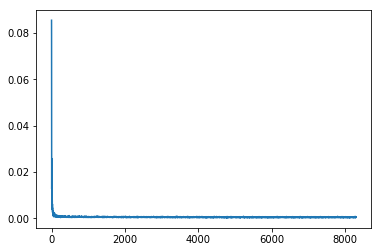

In [15]:
from matplotlib import pyplot as plt
plt.plot(loss_list)
plt.show()

In [16]:
# Guardamos el ultimo modelo
checkpoint_path_model = os.path.join('sin_KP_NoN_Zara01_social12_F', 'model.ckpt')
saver.save(sess,checkpoint_path_model , global_step = global_step)

'sin_KP_NoN_Zara01_social12_F/model.ckpt-8300'

# Restauramos los modelos

In [17]:
#Ultimo Modelo
path_model = 'sin_KP_NoN_Zara01_social12_F/model.ckpt-8300'
saver.restore(sess=sess, save_path=path_model)


test_data = batches_data.Dataset(data2, arguments)
print('Evaluating')
results = evaluate(test_data, tester,sess,arguments)
print(results)

W1227 08:27:23.855240 139680819443456 deprecation.py:323] From /home/andrea/anaconda2/lib/python2.7/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
 33%|###3      | 8/24 [00:00<00:00, 79.01it/s]

Evaluating


100%|##########| 24/24 [00:00<00:00, 76.13it/s]

{'ade': 0.3761161, 'fde': 0.8078269}


In [19]:
#Modelo12
path_model = 'sin_KP_NoN_Zara01_social12/model.ckpt-8300'
saver.restore(sess=sess, save_path=path_model)


test_data = batches_data.Dataset(data2, arguments)
print('Evaluating')
results = evaluate(test_data, tester,sess,arguments)
print(results)

 29%|##9       | 7/24 [00:00<00:00, 64.34it/s]

Evaluating


100%|##########| 24/24 [00:00<00:00, 66.46it/s]

{'ade': 0.3761161, 'fde': 0.8078269}


In [20]:
# Mejor Modelo
path_model = 'sin_KP_NoN_Zara01_social-best12/model_best.ckpt-6900'
saver.restore(sess=sess, save_path=path_model)

test_data = batches_data.Dataset(data2, arguments)
print('Evaluating')
results = evaluate(test_data, tester,sess,arguments)
print(results)

 29%|##9       | 7/24 [00:00<00:00, 68.23it/s]

Evaluating


100%|##########| 24/24 [00:00<00:00, 76.60it/s]

{'ade': 0.37608832, 'fde': 0.8078438}
